In [20]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal, Annotated
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import os

In [21]:
load_dotenv()
generator_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

evaluator_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

optimizer_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.7,
    google_api_key=os.getenv("GOOGLE_API_KEY")
)

In [22]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [ ]:
class postGenerator(TypedDict):
    post_topic: str
    post: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iterations: int 


def generate_post(state: postGenerator) -> postGenerator:
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['post_topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    post = generator_llm.invoke(messages).content
    return {"post": post, "iteration": 0}


def evaluate_post(state: postGenerator) -> postGenerator:
    messages = [
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['post']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
    ]

    response = structured_evaluator_llm.invoke(messages)
    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback
    }

def optimize_post(state: postGenerator) -> postGenerator: 
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['post_topic']}"
Original Tweet:
{state['post']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]
    response = optimizer_llm.invoke(messages).content
    iteration = state.get("iteration", 0) + 1
    return {"post": response, "iteration": iteration}

In [28]:
def route_evaluation(state: postGenerator) -> Literal["optimize_post", "__end__"]:
    if state['evaluation'] == "approved":
        return "__end__"
    elif state['evaluation'] == "needs_improvement" and state['iteration'] < state['max_iterations']:
        return "optimize_post"
    else:
        return "__end__"

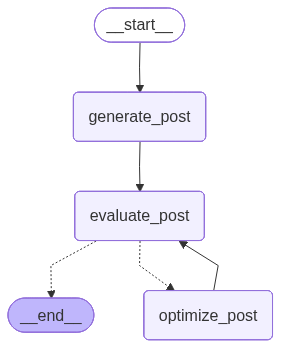

In [29]:
graph = StateGraph(postGenerator) 

# add edges: 
graph.add_node("generate_post", generate_post) 
graph.add_node("evaluate_post", evaluate_post) 
graph.add_node("optimize_post", optimize_post) 

# add edges
graph.add_edge(START, "generate_post")
graph.add_edge("generate_post", "evaluate_post")
graph.add_conditional_edges("evaluate_post", route_evaluation)
graph.add_edge("optimize_post", "evaluate_post")


workflow = graph.compile()
workflow



In [32]:
input_data = {
    "post_topic": "the joys and challenges of remote work",
    "max_iterations": 3
} 
workflow.invoke(input_data)

KeyboardInterrupt: 